In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import birdsonganalysis as bsa
from copy import deepcopy
from os.path import join, isdir, exists
import json
import pandas as pd
import pickle
from scipy.io import wavfile
from syllable_cluster import *

from ipywidgets.widgets import FloatProgress
from IPython.display import display

import sys

sys.path.append('../model')

from song_model import SongModel

sns.set_palette('colorblind')
%matplotlib notebook
import itertools

In [2]:
main_path = '../model/res/diversity_weight/seed{}+big_ba+15_conc+3_day_conc+{}_diversity_weight+small_bloat_weight/'
rds = dict()
songlogs = dict()

for seed, div in itertools.product(range(40), [1, 125, 15, 2, 3, 10]):
    if not isdir(main_path.format(seed, div)) or not exists(join(main_path.format(seed, div), 'data.pkl')):
        continue
    path = main_path.format(seed, div)
    with open(join(path, 'data.pkl'), 'rb') as f:
            songlogs[seed, div] = pickle.load(f)
    root_data = [item[1] for item in songlogs[seed, div] if item[0] == 'root']
    for i in range(len(root_data)):
        root_data[i]['day'] = i//2+1
        if root_data[i]['moment'] in ['Start', 'AfterNight']:
            root_data[i]['moment'] = 'morning'
        else:
            root_data[i]['moment'] = 'evening'
    rds[seed, div] = pd.DataFrame(root_data)

sr, tutor = wavfile.read(join(path, 'tutor.wav'))

In [3]:
data = []
for (seed, div), df in rds.items():
    a = df.query('moment == "morning"').iloc[1:]['scores'] 
    b = df.query('moment == "evening"').iloc[:-1]['scores']
    unlearning = np.mean(np.array(a.map(np.mean)) - np.array(b.map(np.mean)))
    end = np.mean(df.iloc[-1]['scores'])
    sim  = bsa.similarity(df.iloc[-1]['songs'][np.argmin(df.iloc[-1]['scores'])].gen_sound(), tutor)['similarity']
    div_s = div
    while div_s > 10:
        div_s /= 10
    data.append({'bird': seed * 1000 + div, 'div': div_s, 'night_loss': unlearning, 'end': end, 'sim': sim})

In [4]:
data_df = pd.DataFrame(data)
data_df.sort_values('sim')

,bird,div,end,night_loss,sim
11,5001,1.00,301.905942,60.686682,0.134665
10,10125,1.25,259.614097,66.282644,0.148759
31,8015,1.50,195.854023,54.393990,0.164169
8,10001,1.00,286.240326,61.080599,0.215533
32,10002,2.00,295.941179,56.874980,0.258834
1,1002,2.00,165.200474,27.368866,0.308437
5,10015,1.50,196.780737,68.153060,0.308660
17,10003,3.00,346.608275,77.207865,0.344764
19,15,1.50,169.887715,46.644395,0.380546
21,8001,1.00,321.539303,57.556515,0.393077


<IPython.core.display.Javascript object>


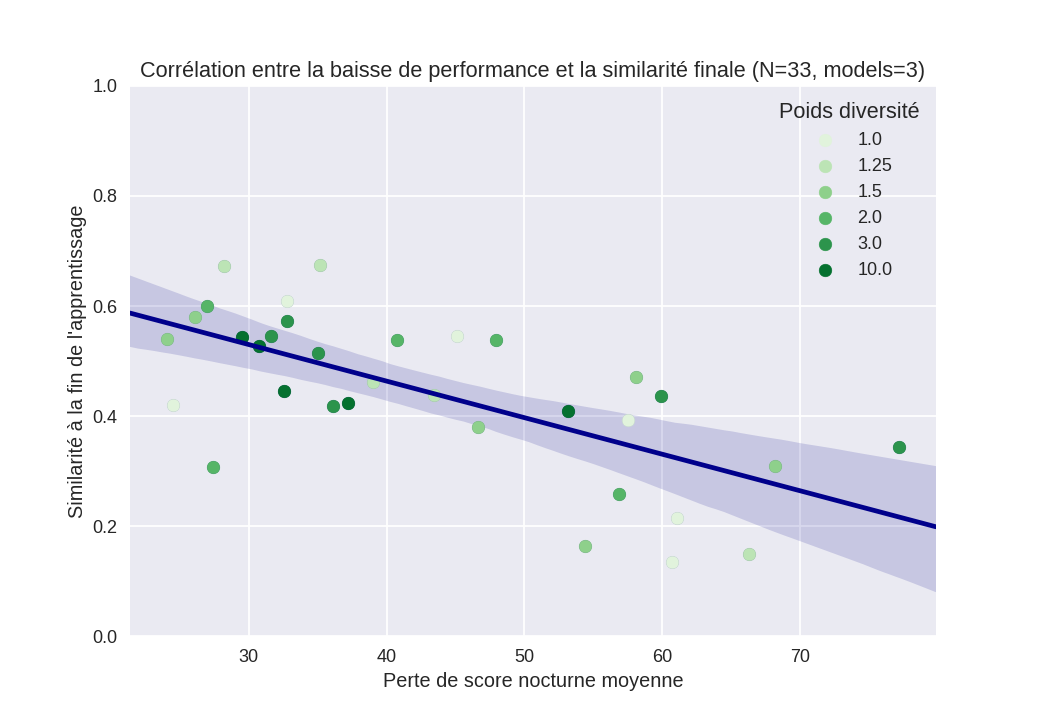

In [5]:
sns.set_context('talk')
plt.figure()
with sns.color_palette('Greens', 6):
    ax = sns.regplot(x='night_loss', y='sim', data=data_df, color='darkblue', marker='o')
    for div in sorted(data_df['div'].unique()):
        ax.scatter(data_df.query('div == {}'.format(div))['night_loss'], data_df.query('div == {}'.format(div))['sim'], label='{}'.format(div))
    ax.legend(title='Poids diversité')
    ax.set_ylabel('Similarité à la fin de l\'apprentissage')
    ax.set_xlabel('Perte de score nocturne moyenne')
    ax.set_ylim((0, 1))
    ax.set_title('Corrélation entre la baisse de performance et la similarité finale (N={}, models=3)'.format(len(data_df)))
plt.show()

(-0.19293509253065652, 0.28204366960508392)


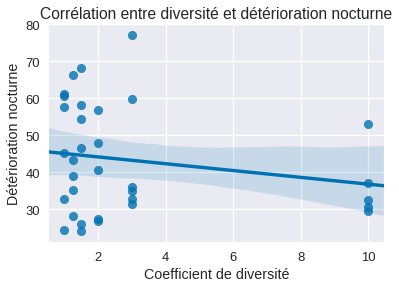

In [20]:
sns.set_context('talk')

plt.figure(figsize=(6, 4))
data_df['logdiv'] = data_df['div'].apply(np.log)
ax = sns.regplot(data=data_df, x='div', y='night_loss')
ax.set_ylabel('Détérioration nocturne')
ax.set_xlabel('Coefficient de diversité')
ax.set_title('Corrélation entre diversité et détérioration nocturne')
print(scipy.stats.pearsonr(data_df['div'], data_df['night_loss']))

(0.11269750676899541, 0.53234547954276712)


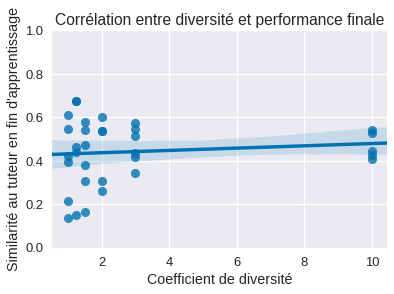

In [21]:
plt.figure(figsize=(6, 4))
data_df['logdiv'] = data_df['div'].apply(np.log)
ax = sns.regplot(data=data_df, x='div', y='sim')
ax.set_ylabel('Similarité au tuteur en fin d\'apprentissage')
ax.set_xlabel('Coefficient de diversité')
ax.set_title('Corrélation entre diversité et performance finale')
plt.ylim((0, 1))
print(scipy.stats.pearsonr(data_df['div'], data_df['sim']))

In [8]:
a = df.query('moment == "morning"').iloc[1:]['scores'] 
b = df.query('moment == "evening"').iloc[:-1]['scores']

np.array(a.map(np.mean)) - np.array(b.map(np.mean))



array([  -5.50812811,   29.91677305,   28.78469667,  120.35643159,
        132.15117102,  -21.9605747 ,   27.14635785,  249.5332016 ,
          2.79896293,   91.26720398,   59.65456832,   43.19445382,
         30.89817726,   26.43766925,  105.00533422,   18.85896397,
         47.9516774 ,   63.8229772 ,   80.86012205,   31.08191582,
         28.9542727 ,   39.84121932,   24.90351972,   69.18975849,
         33.3764205 ,   79.73510569,   92.37532904,   68.23715951,
         88.80795665,   49.45426972,   14.08975557,    9.90511532,
         21.56844813,   57.61634716,   52.27035114,   37.76776459,
         94.82319622,    0.77609737,   50.12377251,   22.49380891,
         83.13721705,   50.21123995,   66.30140335,   75.09995291,
         25.86990134,   64.55841756,  135.44766059,  125.03309346,
         62.65348701])

In [9]:
data = []
for (seed, div), df in rds.items():
    a = df.query('moment == "morning"').iloc[1:]['scores'] 
    b = df.query('moment == "evening"').iloc[:-1]['scores']
    unlearning = np.array(a.map(np.mean)) - np.array(b.map(np.mean))
    div_s = div
    while div_s > 10:
        div_s /= 10
    for day, day_to_day_unlearn in enumerate(unlearning):
        data.append({'bird': seed * 1000 + div, 'div': div_s, 'day': day+1, 'loss': -day_to_day_unlearn})

In [10]:
loss_df = pd.DataFrame(data)

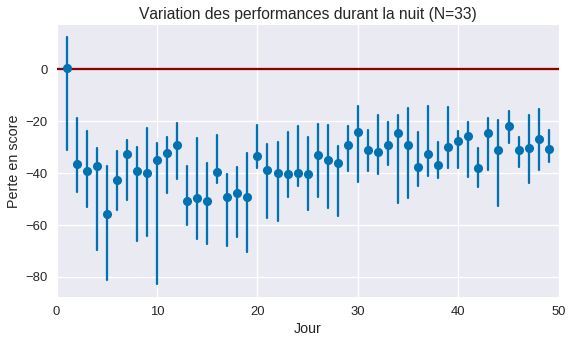

In [14]:
%matplotlib inline
sns.set_context('talk')
plt.figure(figsize=(9, 5))
ax = plt.gca()
ax.axhline(0, color="darkred")
ax = sns.tsplot(data=loss_df, unit='bird', time='day', value='loss', interpolate=False, err_style='ci_bars', ci=95, estimator=np.nanmedian, ax=ax)
ax.set_ylabel('Perte en score')
ax.set_xlabel('Jour')
ax.set_title('Variation des performances durant la nuit (N={})'.format(len(loss_df['bird'].unique())))
plt.show()